In [1]:
import json
import pickle
import numpy as np
import matplotlib.pyplot as plt
from trieste.observer import INEQUALITY_CONSTRAINT_PREFIX, OBJECTIVE

plt.style.use('plot_style.txt')

OBJECTIVE = "OBJECTIVE"
INEQUALITY_CONSTRAINT_ONE = "INEQUALITY_CONSTRAINT_ONE"
INEQUALITY_CONSTRAINT_TWO = "INEQUALITY_CONSTRAINT_TWO"

2023-10-15 14:59:58.581026: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def process_results(result_dir: str,
                    num_runs: int,
                    failure_val: float,
                    objective_multiplier: float):
    all_results = []
    for run in range(num_runs):
        run_file = result_dir + f"run_{run}_data.pkl"
        with open(run_file, "rb") as fp:
            run_data = pickle.load(fp)
        satisfied_mask = np.full(shape=run_data[OBJECTIVE].observations.shape[0], fill_value=True)
        for key in run_data.keys():
            if key.startswith(INEQUALITY_CONSTRAINT_PREFIX):
                inequality_constraint_satisfied = run_data[key].observations.numpy().squeeze() <= 0
                satisfied_mask = np.logical_and(satisfied_mask, inequality_constraint_satisfied)
        failure_mask = np.logical_not(satisfied_mask)
        objective_vals = run_data[OBJECTIVE].observations.numpy().squeeze()
        objective_vals = objective_vals * objective_multiplier
        safe_obs_values = objective_vals.copy()
        safe_obs_values[failure_mask] = failure_val
        all_results.append(np.minimum.accumulate(safe_obs_values))
    all_results = np.array(all_results)
    all_results_mean = np.mean(all_results, axis=0)
    all_results_median = np.median(all_results, axis=0)
    all_results_std = np.std(all_results, axis=0)
    return all_results, all_results_mean, all_results_median, all_results_std

In [3]:
def process_ei_al_results(result_dir: str,
                          num_runs: int,
                          failure_val: float,
                          objective_multiplier: float):
    all_results = []
    for run in range(1, num_runs + 1):
        run_file = result_dir + f"run_{run}_results.json"
        with open(run_file, "rb") as fp:
            all_run_data = json.load(fp)
            run_results = all_run_data["prog"]
            i = 0
            while i < len(run_results) and run_results[i] == "Inf":
                i += 1
            if i > 0:
                for j in range(i):
                    run_results[j] = failure_val / objective_multiplier
            run_results = run_results
            all_results.append(np.minimum.accumulate(run_results))
    all_results = np.array(all_results)
    all_results = np.multiply(all_results, objective_multiplier)
    all_results_mean = np.mean(all_results, axis=0)
    all_results_median = np.median(all_results, axis=0)
    all_results_std = np.std(all_results, axis=0)
    return all_results, all_results_mean, all_results_median, all_results_std

### Lockwood

In [10]:
ts_al_lockwood_res, ts_al_lockwood_mean, ts_al_lockwood_median, ts_al_lockwood_std = process_results("final_ts_al_results/lockwood/trust_region/data/", num_runs=30, failure_val=60000.0, objective_multiplier=10000.0)
scbo_lockwood_res, scbo_lockwood_mean, scbo_lockwood_median, sbco_lockwood_std = process_results("final_scbo_results/lockwood/trust_region/data/", num_runs=30, failure_val=60000.0, objective_multiplier=10000.0)
eci_lockwood_res, eci_lockwood_mean, eci_lockwood_median, eci_lockwood_std  = process_results("eci_results/lockwood/data/", num_runs=30, failure_val=60000.0, objective_multiplier=10000.0)
ei_al_lockwood_res, ei_al_lockwood_mean, ei_al_lockwood_median, ei_al_lockwood_std = process_ei_al_results("ei_al_results/lockwood/data/", num_runs=30, failure_val=60000.0, objective_multiplier=10000.0)
random_lockwood_res, random_lockwood_mean, random_lockwood_median, random_lockwood_std  = process_results("random_baseline_results/lockwood/data/", num_runs=30, failure_val=60000.0, objective_multiplier=10000.0)

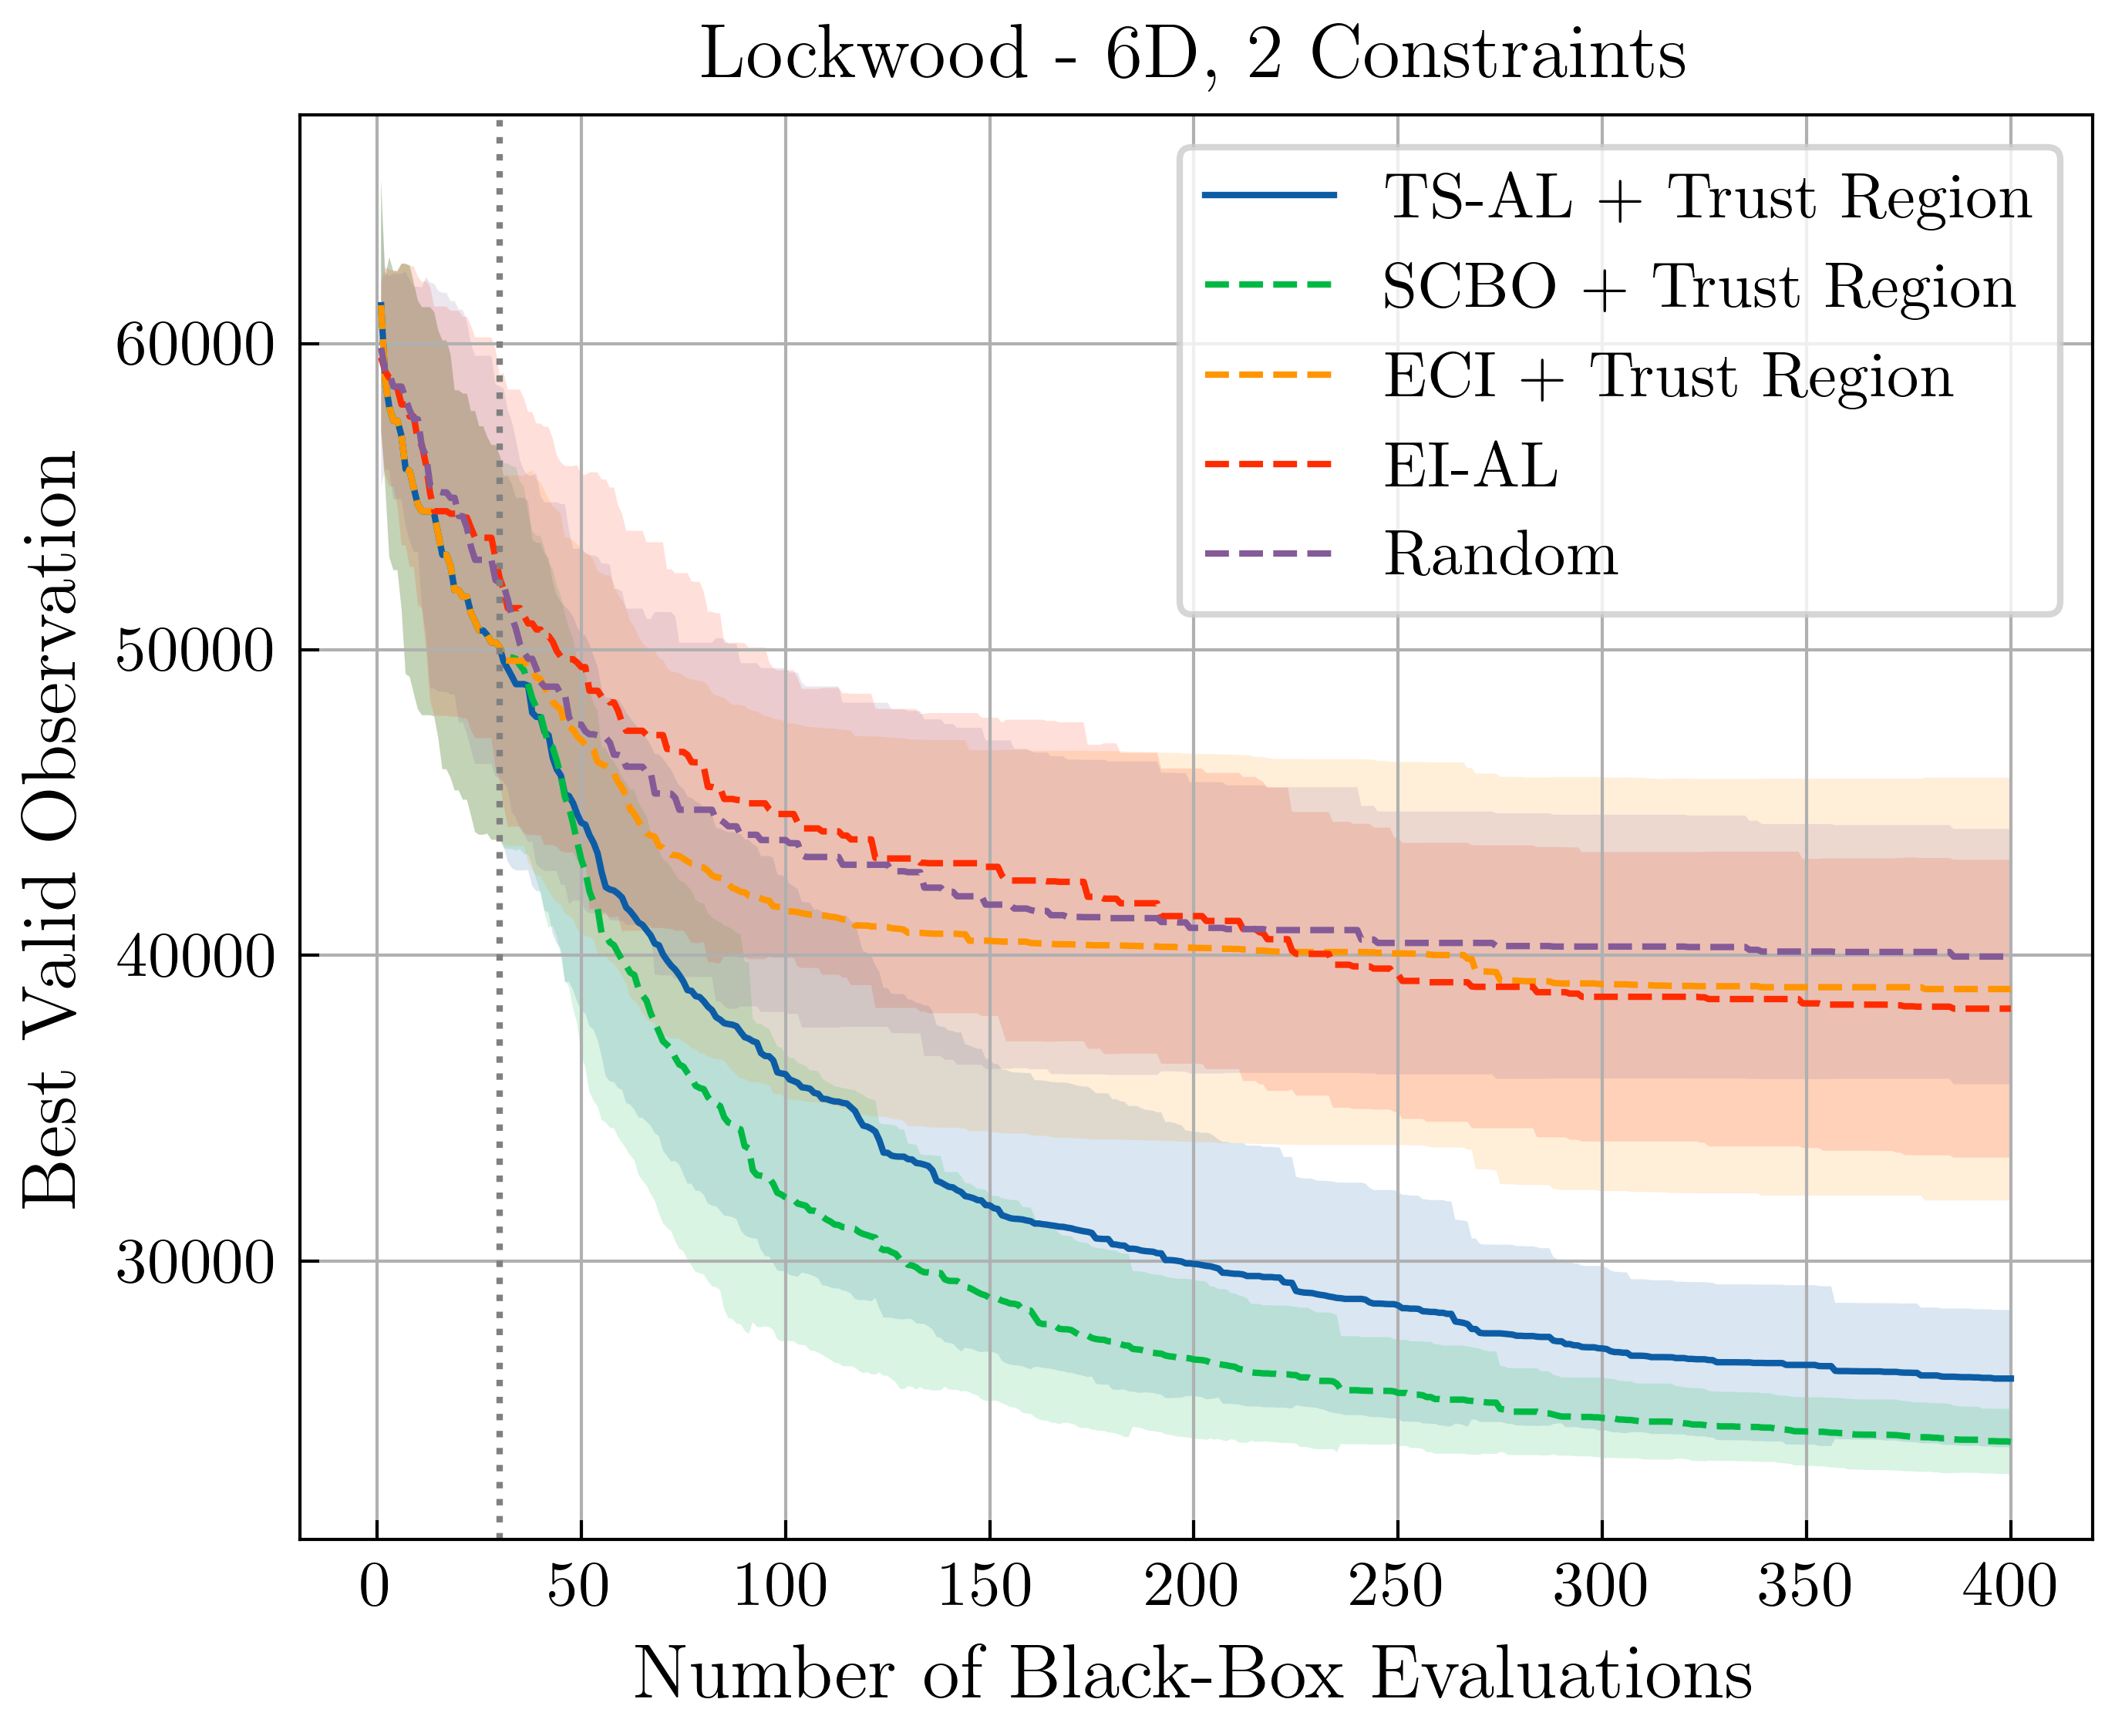

In [26]:
plt.figure(figsize=(5,4))
iters = [i for i in range(1, 401)]
plt.plot(iters, ts_al_lockwood_mean, label="TS-AL + Trust Region")
plt.plot(iters, scbo_lockwood_mean, label="SCBO + Trust Region", linestyle="dashed")
plt.plot(iters, eci_lockwood_mean, label="ECI + Trust Region", linestyle="dashed")
plt.plot(iters, ei_al_lockwood_mean, label="EI-AL", linestyle="dashed")
plt.plot(iters, random_lockwood_mean, label="Random", linestyle="dashed")
plt.fill_between(iters, ts_al_lockwood_mean - ts_al_lockwood_std, ts_al_lockwood_mean + ts_al_lockwood_std, alpha=0.15)
plt.fill_between(iters, scbo_lockwood_mean - sbco_lockwood_std, scbo_lockwood_mean + sbco_lockwood_std, alpha=0.15)
plt.fill_between(iters, eci_lockwood_mean - eci_lockwood_std, eci_lockwood_mean + eci_lockwood_std, alpha=0.15)
plt.fill_between(iters, ei_al_lockwood_mean - ei_al_lockwood_std, ei_al_lockwood_mean + ei_al_lockwood_std, alpha=0.15)
plt.fill_between(iters, random_lockwood_mean - random_lockwood_std, random_lockwood_mean + random_lockwood_std, alpha=0.15)
plt.axvline(x=30, color="grey", linestyle="dotted")
plt.title("Lockwood - 6D, 2 Constraints")
plt.xlabel("Number of Black-Box Evaluations")
plt.ylabel("Best Valid Observation")
plt.legend()
# plt.savefig("paper_figs/lockwood.png")

### Ackley10

In [14]:
random_ackley_10_res, random_ackley_10_mean, random_ackley_10_median, random_ackley_10_std = process_results("random_baseline_results/ackley_10/data/", num_runs=30, failure_val=10.0, objective_multiplier=10.0)
scbo_ackley_10_res, scbo_ackley_10_mean, scbo_ackley_10_median, scbo_ackley_10_std = process_results("final_scbo_results/updated_ackley_10/trust_region/data/", num_runs=30, failure_val=10.0, objective_multiplier=10.0)
ts_al_ackley_10_res, ts_al_ackley_10_mean, ts_al_ackley_10_median, ts_al_ackley_10_std = process_results("final_ts_al_results/updated_ackley_10/trust_region/data/", num_runs=30, failure_val=10.0, objective_multiplier=10.0)
eci_ackley_10_res, eci_ackley_10_mean, eci_ackley_10_median, eci_ackley_10_std = process_results("eci_results/ackley_10/data/", num_runs=30, failure_val=10.0, objective_multiplier=10.0)
ei_al_ackley_10_res, ei_al_ackley_10_mean, ei_al_ackley_10_median, ei_al_ackley_10_std = process_ei_al_results("ei_al_results/ackley_10/slack_optim_no_ey/data/", num_runs=30, failure_val=10.0, objective_multiplier=10.0)

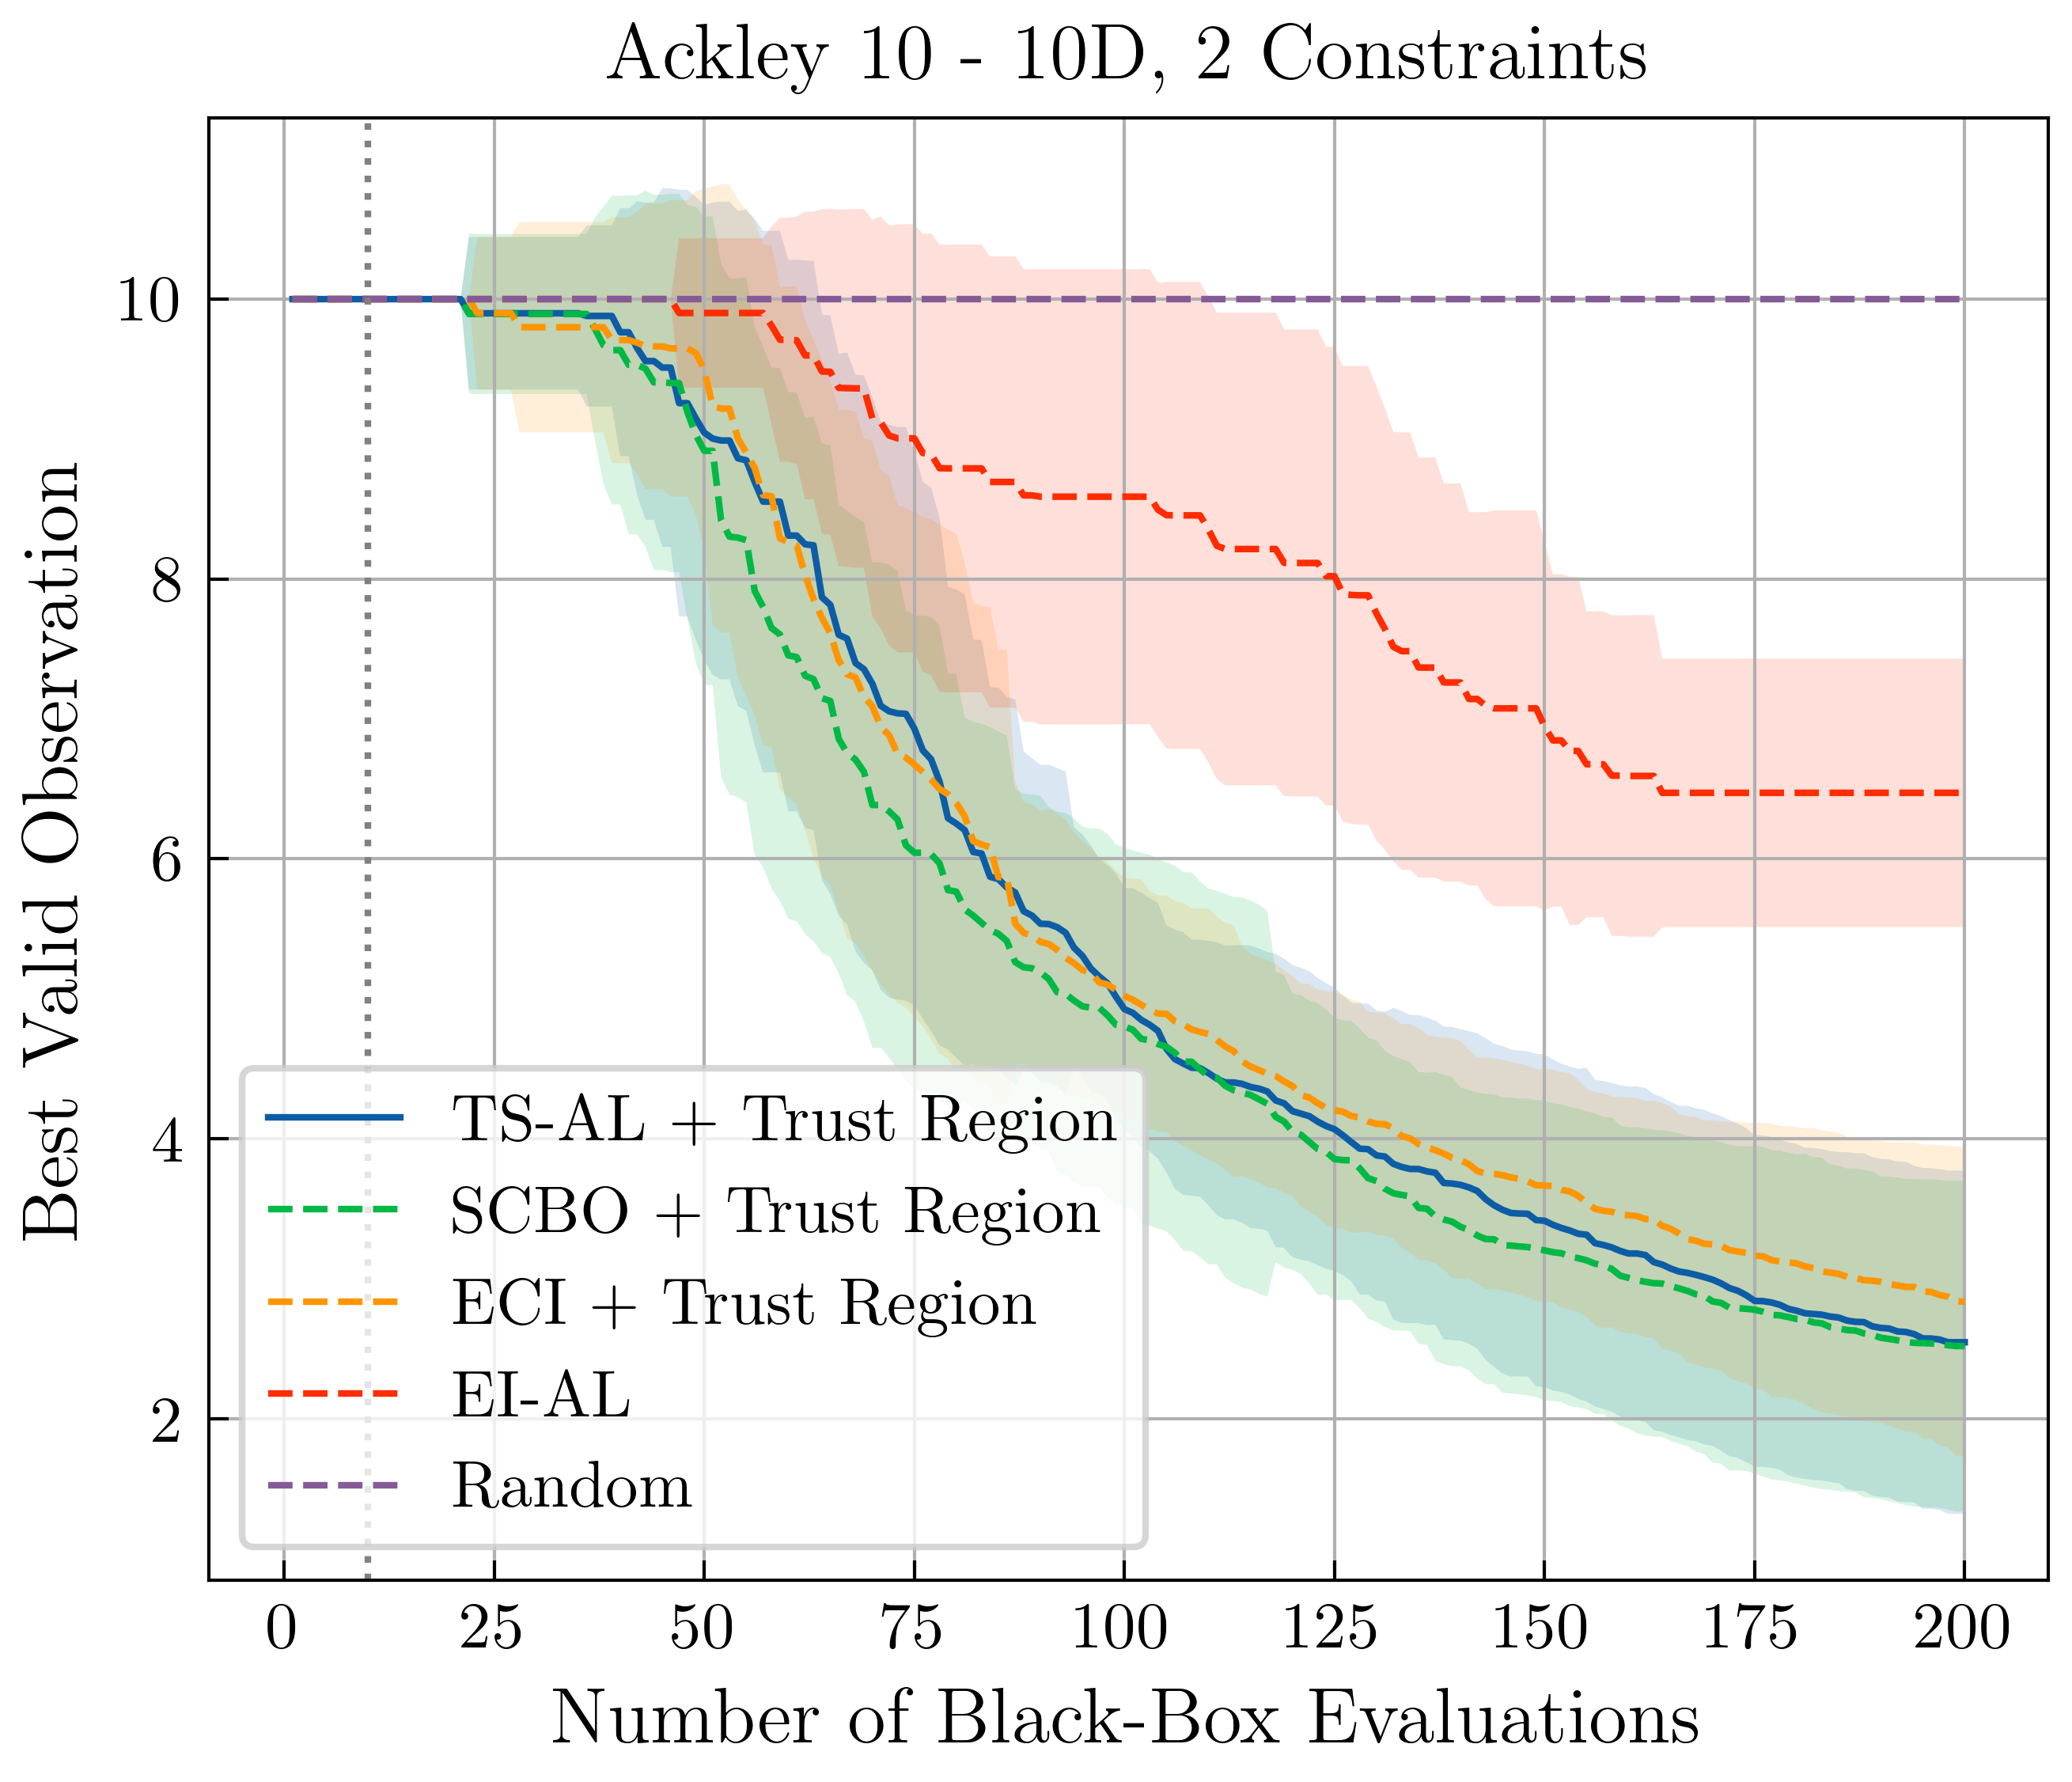

In [28]:
plt.figure(figsize=(5,4))
iters  = [i for i in range(1, 201)]
plt.plot(iters, ts_al_ackley_10_mean, label="TS-AL + Trust Region")
plt.plot(iters, scbo_ackley_10_mean, label="SCBO + Trust Region", linestyle="dashed")
plt.plot(iters, eci_ackley_10_mean, label="ECI + Trust Region", linestyle="dashed")
plt.plot(iters, ei_al_ackley_10_mean, label="EI-AL", linestyle="dashed")
plt.plot(iters, random_ackley_10_mean, label="Random", linestyle="dashed")
plt.fill_between(iters, ts_al_ackley_10_mean - ts_al_ackley_10_std, ts_al_ackley_10_mean + ts_al_ackley_10_std, alpha=0.15)
plt.fill_between(iters, scbo_ackley_10_mean - scbo_ackley_10_std, scbo_ackley_10_mean + scbo_ackley_10_std, alpha=0.15)
plt.fill_between(iters, eci_ackley_10_mean - eci_ackley_10_std, eci_ackley_10_mean + eci_ackley_10_std, alpha=0.15)
plt.fill_between(iters, ei_al_ackley_10_mean - ei_al_ackley_10_std, ei_al_ackley_10_mean + ei_al_ackley_10_std, alpha=0.15)
plt.fill_between(iters, random_ackley_10_mean - random_ackley_10_std, random_ackley_10_mean + random_ackley_10_std, alpha=0.15)
plt.axvline(x=10, color="grey", linestyle="dotted")
plt.title("Ackley 10 - 10D, 2 Constraints")
plt.xlabel("Number of Black-Box Evaluations")
plt.ylabel("Best Valid Observation")
plt.legend()
# plt.savefig("paper_figs/ackley_10.png")

### Keane30

In [16]:
random_keane_30_res, random_keane_30_mean, random_keane_30_median, random_keane_30_std = process_results("random_baseline_results/keane_30/data/", num_runs=30, failure_val=-0.1, objective_multiplier=0.1)
scbo_keane_30_res, scbo_keane_30_mean, scbo_keane_30_median, scbo_keane_30_std = process_results("final_scbo_results/updated_keane_30/data/", num_runs=30, failure_val=-0.1, objective_multiplier=0.1)
ts_al_keane_30_res, ts_al_keane_30_mean, ts_al_keane_30_median, ts_al_keane_30_std = process_results("final_ts_al_results/updated_keane_30/data/", num_runs=30, failure_val=-0.1, objective_multiplier=0.1)
eci_keane_30_res, eci_keane_30_mean, eci_keane_30_median, eci_keane_30_std = process_results("eci_results/keane_30/data/", num_runs=30, failure_val=-0.1, objective_multiplier=0.1)

In [82]:
print(f"Mean: {scbo_keane_30_mean[-1]} STD: {scbo_keane_30_std[-1]}")

Mean: -0.3228333060766831 STD: 0.08055165920980545


In [84]:
print(f"Mean: {ts_al_keane_30_mean[-1]} STD: {ts_al_keane_30_std[-1]}")

Mean: -0.3491032964788262 STD: 0.08334281841152417


In [85]:
print(f"Mean: {eci_keane_30_mean[-1]} STD: {eci_keane_30_std[-1]}")

Mean: -0.32042663265125065 STD: 0.04827715065242946


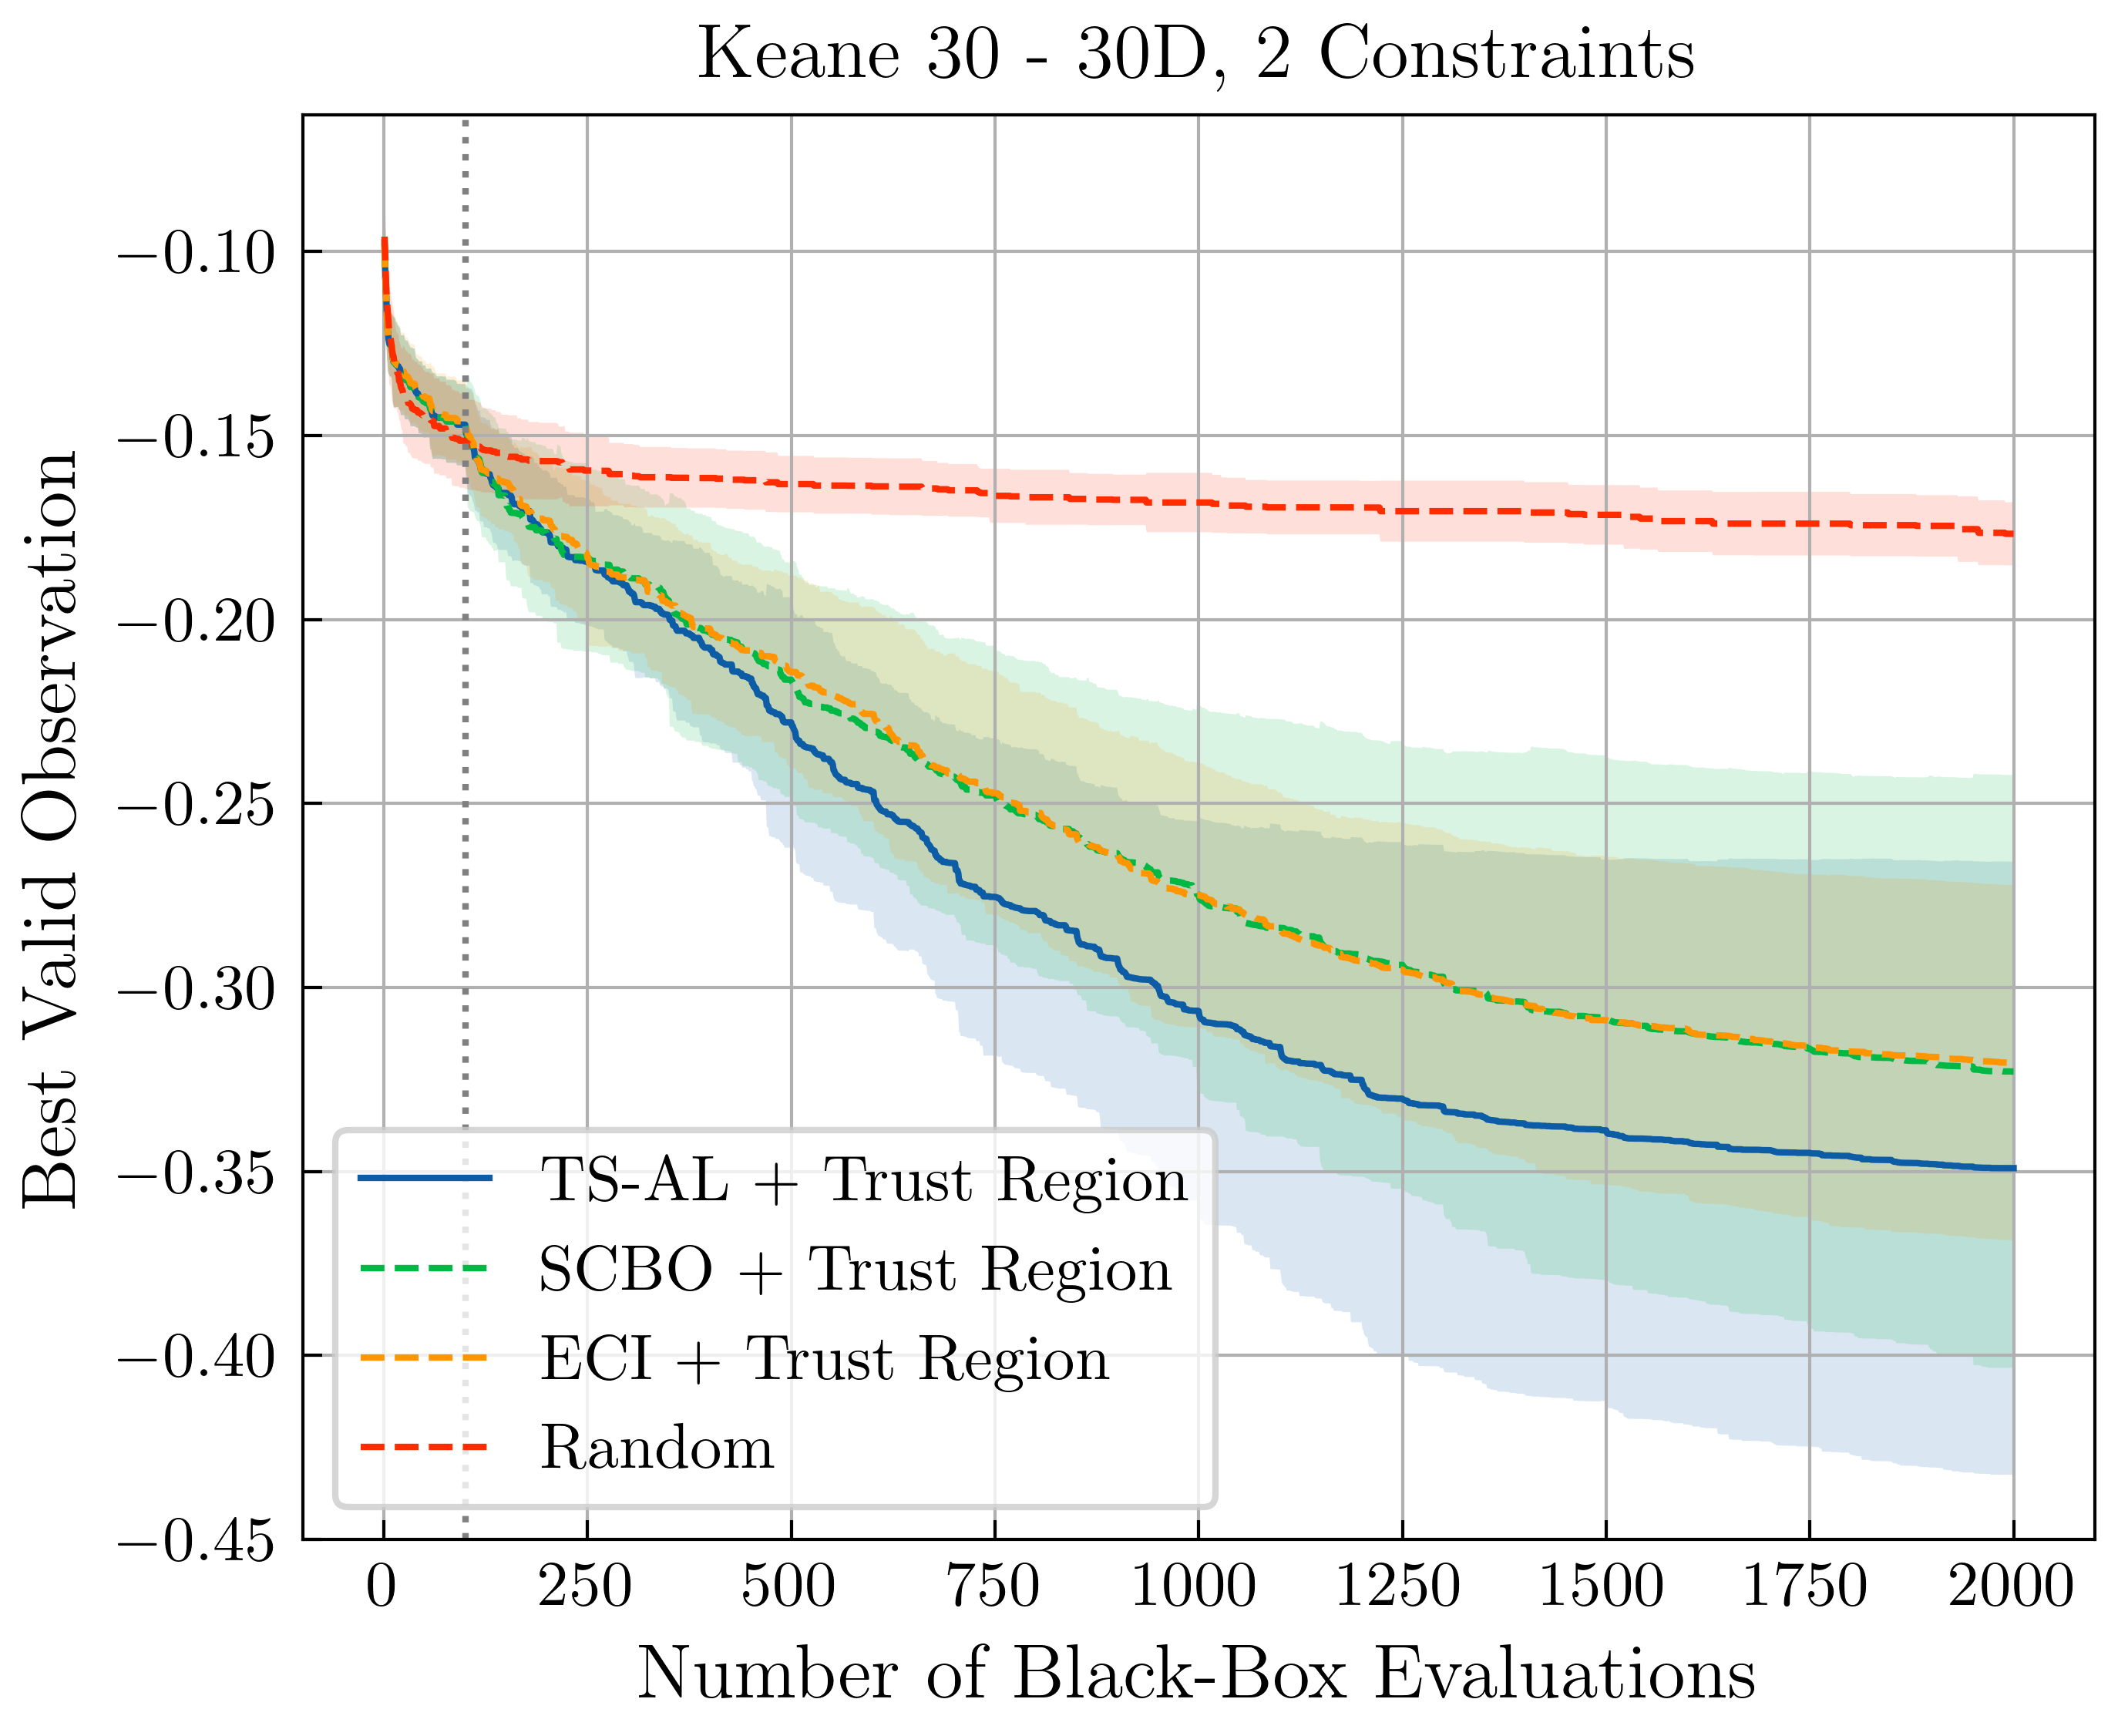

In [58]:
plt.figure(figsize=(5,4))
iters = [i for i in range(1, 2001)]
plt.plot(iters, ts_al_keane_30_mean, label="TS-AL + Trust Region")
plt.plot(iters, scbo_keane_30_mean, label="SCBO + Trust Region", linestyle="dashed")
plt.plot(iters, eci_keane_30_mean, label="ECI + Trust Region", linestyle="dashed")
plt.plot(iters, random_keane_30_mean, label="Random", linestyle="dashed")
plt.fill_between(iters, ts_al_keane_30_mean - ts_al_keane_30_std, ts_al_keane_30_mean + ts_al_keane_30_std, alpha=0.15)
plt.fill_between(iters, scbo_keane_30_mean - scbo_keane_30_std, scbo_keane_30_mean + scbo_keane_30_std, alpha=0.15)
plt.fill_between(iters, eci_keane_30_mean - eci_keane_30_std, eci_keane_30_mean + eci_keane_30_std, alpha=0.15)
plt.fill_between(iters, random_keane_30_mean - random_keane_30_std, random_keane_30_mean + random_keane_30_std, alpha=0.15)
plt.axvline(x=100, color="grey", linestyle="dotted")
plt.title("Keane 30 - 30D, 2 Constraints")
plt.xlabel("Number of Black-Box Evaluations")
plt.ylabel("Best Valid Observation")
plt.legend()
# plt.savefig("paper_figs/keane_30.png")

### Mazda

In [38]:
def worst_feasible_point(result_dir: str,
                         num_runs: int,
                         failure_val: float,
                         objective_multiplier: float):
    all_results = []
    for run in range(num_runs):
        run_file = result_dir + f"run_{run}_data.pkl"
        with open(run_file, "rb") as fp:
            run_data = pickle.load(fp)
        satisfied_mask = np.full(shape=run_data[OBJECTIVE].observations.shape[0], fill_value=True)
        for key in run_data.keys():
            if key.startswith(INEQUALITY_CONSTRAINT_PREFIX):
                inequality_constraint_satisfied = run_data[key].observations.numpy().squeeze() <= 0
                satisfied_mask = np.logical_and(satisfied_mask, inequality_constraint_satisfied)
        failure_mask = np.logical_not(satisfied_mask)
        objective_vals = run_data[OBJECTIVE].observations.numpy().squeeze()
        objective_vals = objective_vals * objective_multiplier
        safe_obs_values = objective_vals.copy()
        print(max(safe_obs_values[satisfied_mask]))
        safe_obs_values[failure_mask] = failure_val
        all_results.append(np.minimum.accumulate(safe_obs_values))
    all_results = np.array(all_results)
    all_results_mean = np.mean(all_results, axis=0)
    all_results_median = np.median(all_results, axis=0)
    all_results_std = np.std(all_results, axis=0)
    return all_results, all_results_mean, all_results_median, all_results_std

In [46]:
random_mazda_res, random_mazda_mean, random_mazda_median, random_mazda_std = process_results("random_baseline_results/mazda/data/", num_runs=6, failure_val=3.15, objective_multiplier=1.0)
scbo_mazda_res, scbo_mazda_mean, scbo_mazda_median, scbo_mazda_std = process_results("final_scbo_results/mazda/data/", num_runs=6, failure_val=3.15, objective_multiplier=1.0)
ts_al_mazda_res, ts_al_mazda_mean, ts_al_mazda_median, ts_al_mazda_std = process_results("final_ts_al_results/mazda/data/", num_runs=6, failure_val=3.15, objective_multiplier=1.0)
eci_mazda_res, eci_mazda_mean, eci_mazda_median, eci_mazda_std = process_results("eci_results/mazda/data/", num_runs=6, failure_val=3.15, objective_multiplier=1.0)

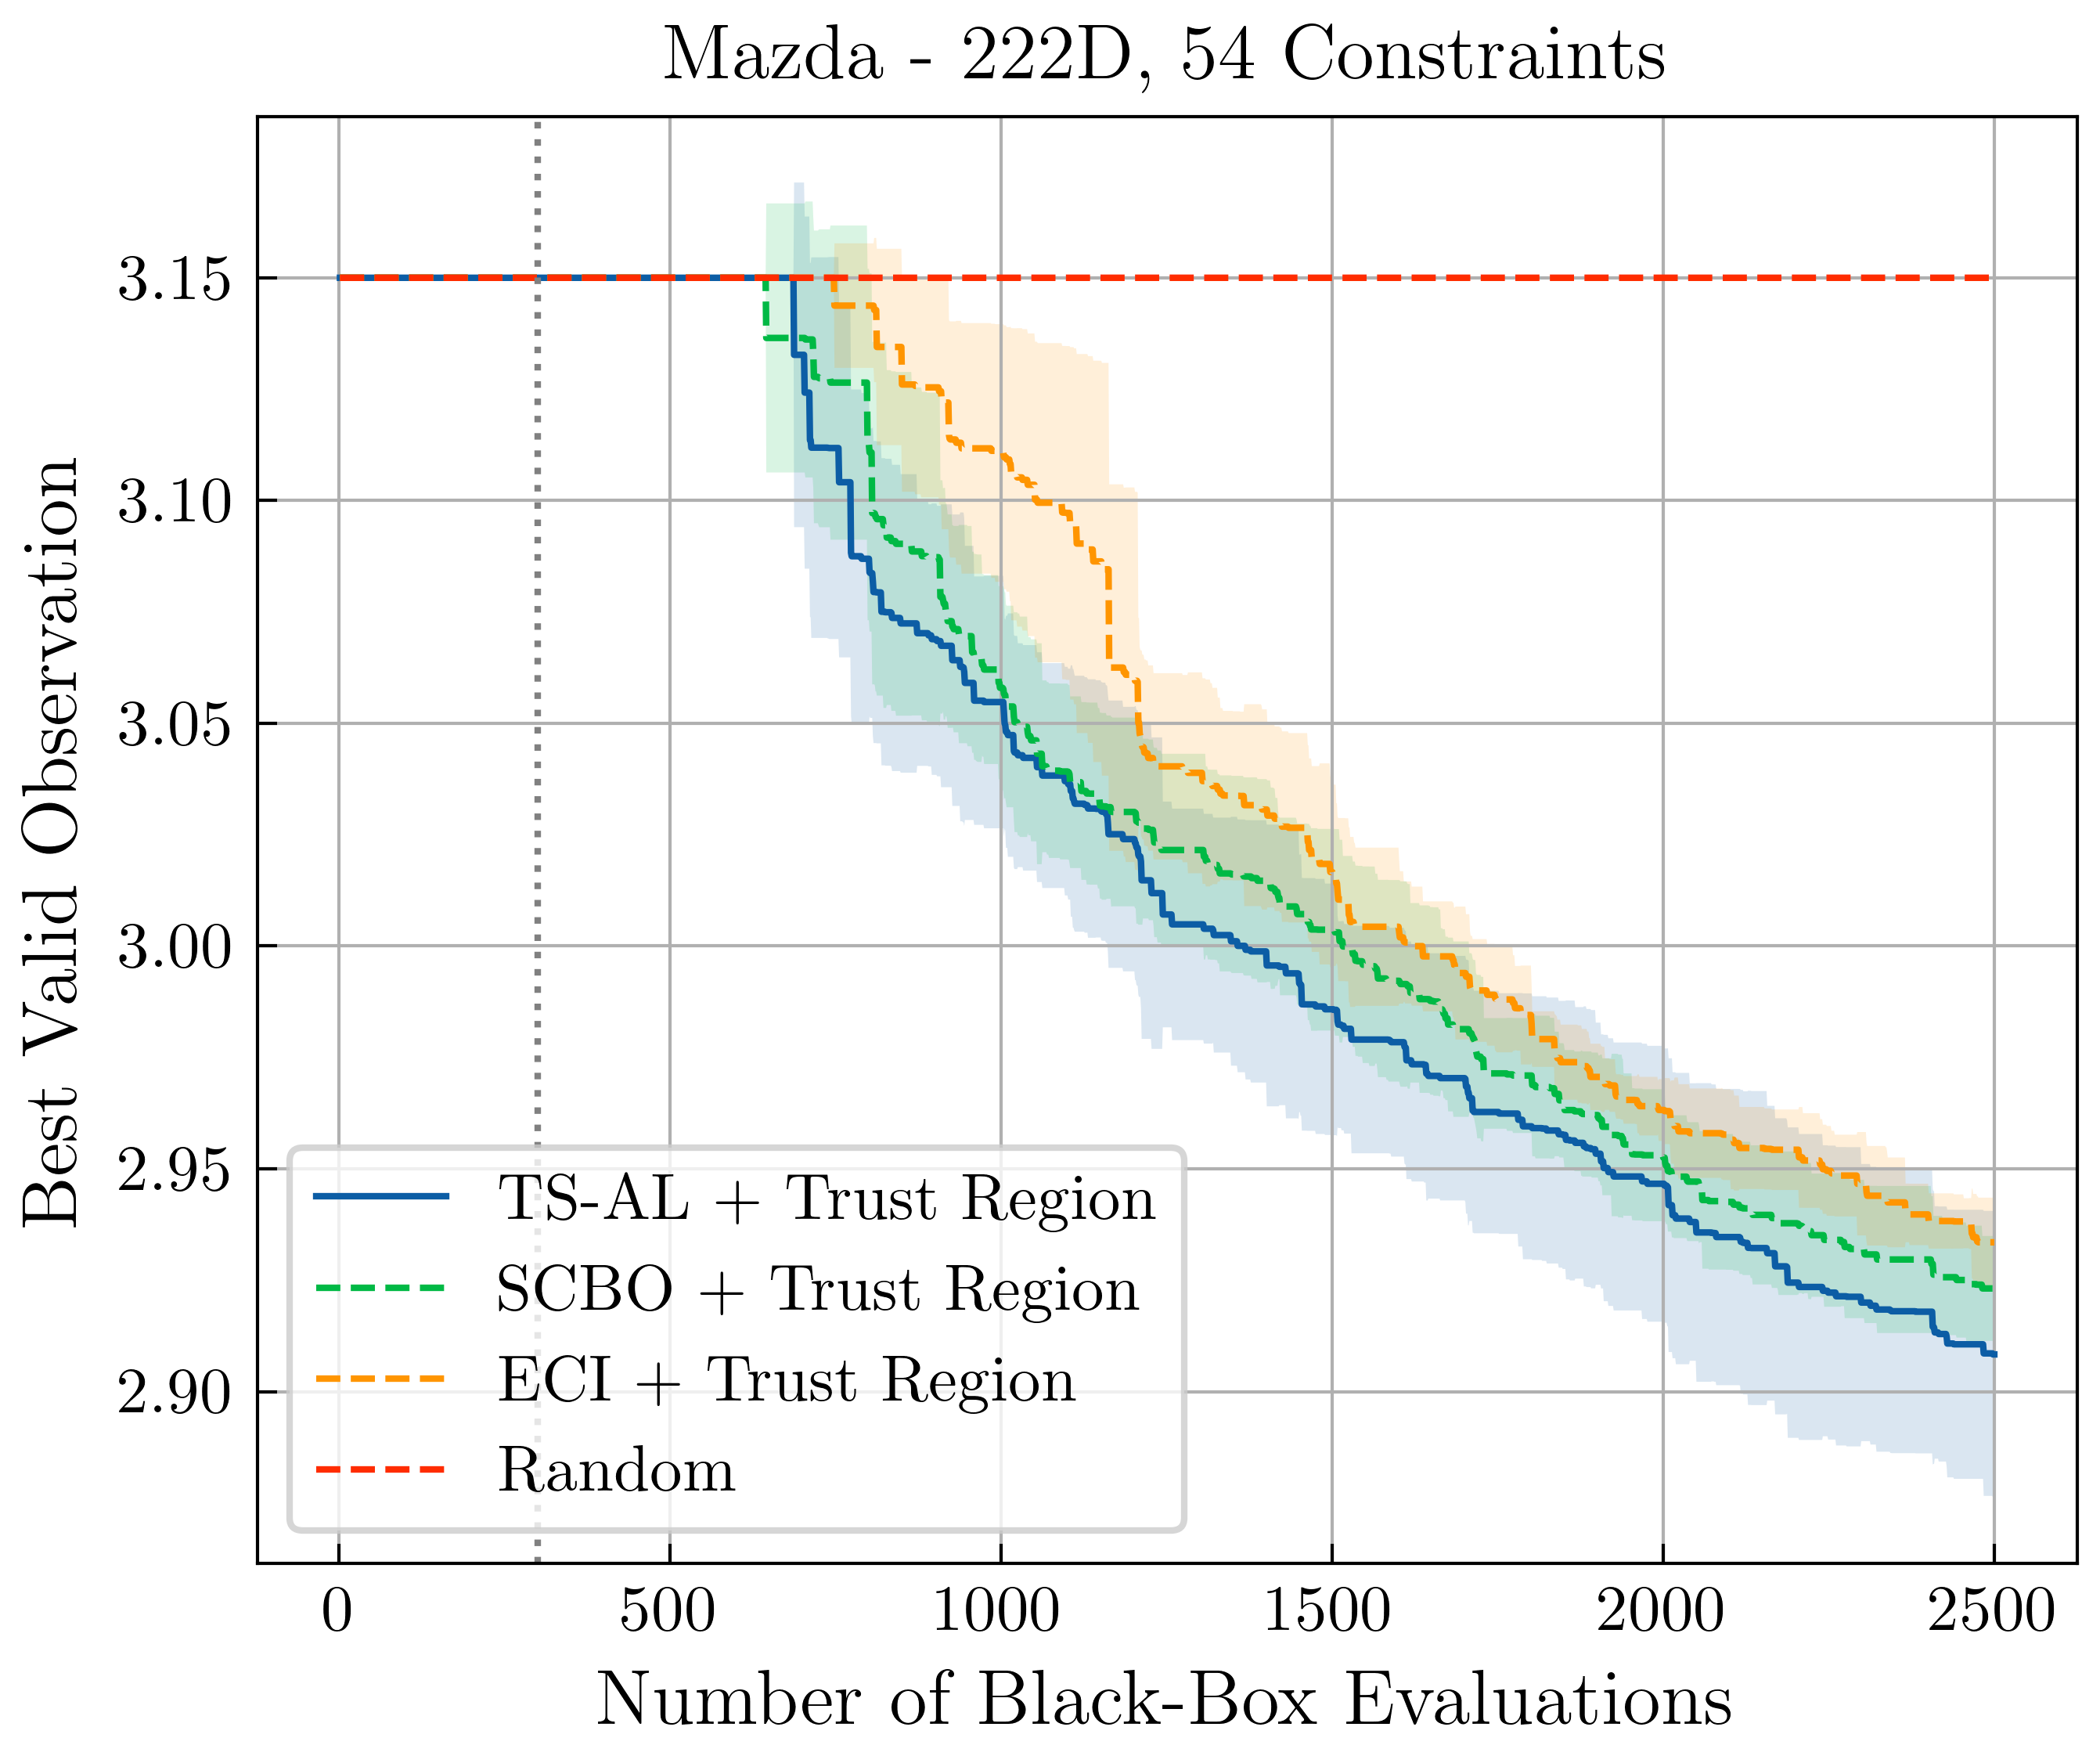

In [47]:
plt.figure(figsize=(5,4))
iters = [i for i in range(1, 2501)]
plt.plot(iters, ts_al_mazda_mean, label="TS-AL + Trust Region")
plt.plot(iters, scbo_mazda_mean, label="SCBO + Trust Region", linestyle="dashed")
plt.plot(iters, eci_mazda_mean, label="ECI + Trust Region", linestyle="dashed")
plt.plot(iters, random_mazda_mean, label="Random", linestyle="dashed")
plt.fill_between(iters, ts_al_mazda_mean - ts_al_mazda_std, ts_al_mazda_mean + ts_al_mazda_std, alpha=0.15)
plt.fill_between(iters, scbo_mazda_mean - scbo_mazda_std, scbo_mazda_mean + scbo_mazda_std, alpha=0.15)
plt.fill_between(iters, eci_mazda_mean - eci_mazda_std, eci_mazda_mean + eci_mazda_std, alpha=0.15)
plt.fill_between(iters, random_mazda_mean - random_mazda_std, random_mazda_mean + random_mazda_std, alpha=0.15)
plt.axvline(x=300, color="grey", linestyle="dotted")
plt.title("Mazda - 222D, 54 Constraints")
plt.xlabel("Number of Black-Box Evaluations")
plt.ylabel("Best Valid Observation")
plt.legend()
# plt.savefig("paper_figs/mazda.png")

In [51]:
ts_al_mazda_frac_valid = np.sum(ts_al_mazda_res < 3.15, axis=0) / 6
scbo_mazda_frac_valid = np.sum(scbo_mazda_res < 3.15, axis=0) / 6
eci_mazda_frac_valid = np.sum(eci_mazda_res < 3.15, axis=0) / 6
random_mazda_frac_valid = np.sum(random_mazda_res < 3.15, axis=0) / 6


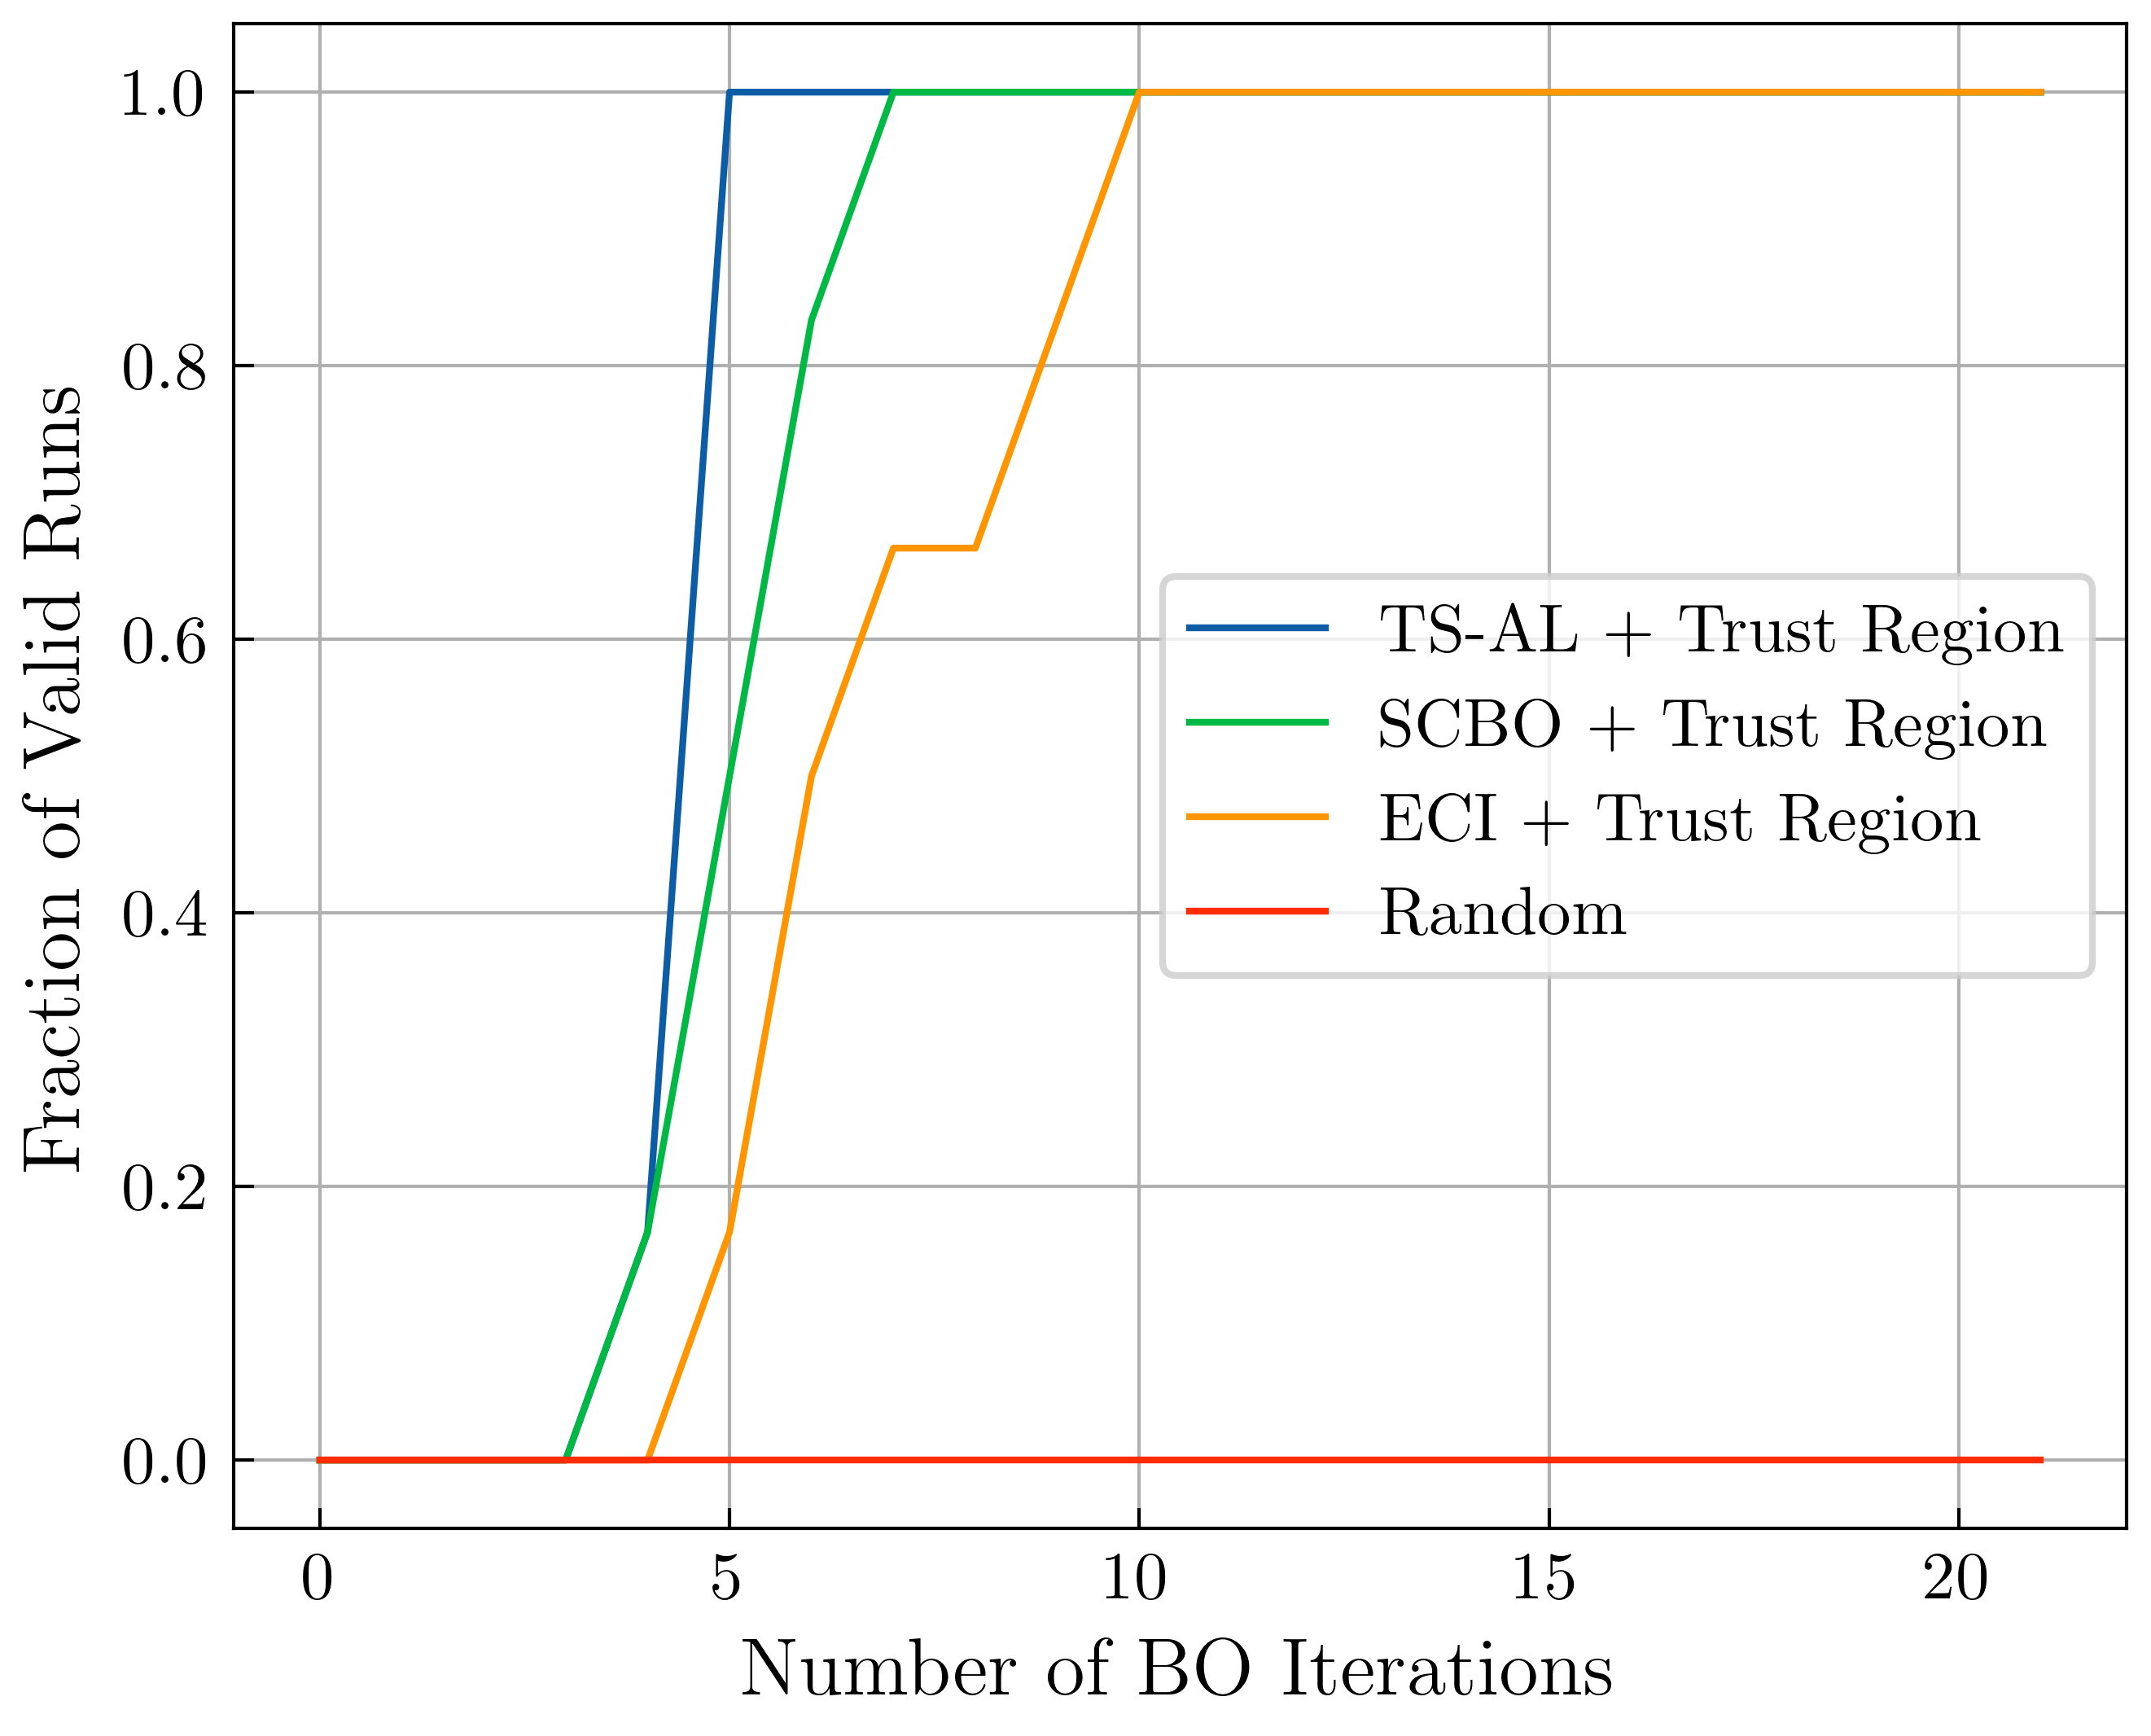

In [52]:
plt.figure(figsize=(5,4))
plt.plot(ts_al_mazda_frac_valid[300:-1:100], label="TS-AL + Trust Region")
plt.plot(scbo_mazda_frac_valid[300:-1:100], label="SCBO + Trust Region")
plt.plot(eci_mazda_frac_valid[300:-1:100], label="ECI + Trust Region")
plt.plot(random_mazda_frac_valid[300:-1:100], label="Random")
plt.title("Mazda - 222D, 54 Constraints")
plt.xlabel("Number of BO Iterations")
plt.ylabel("Fraction of Valid Runs")
plt.legend()
# plt.savefig("paper_figs/mazda_valid_fraction.png")

### Combination

<Figure size 4800x3600 with 0 Axes>

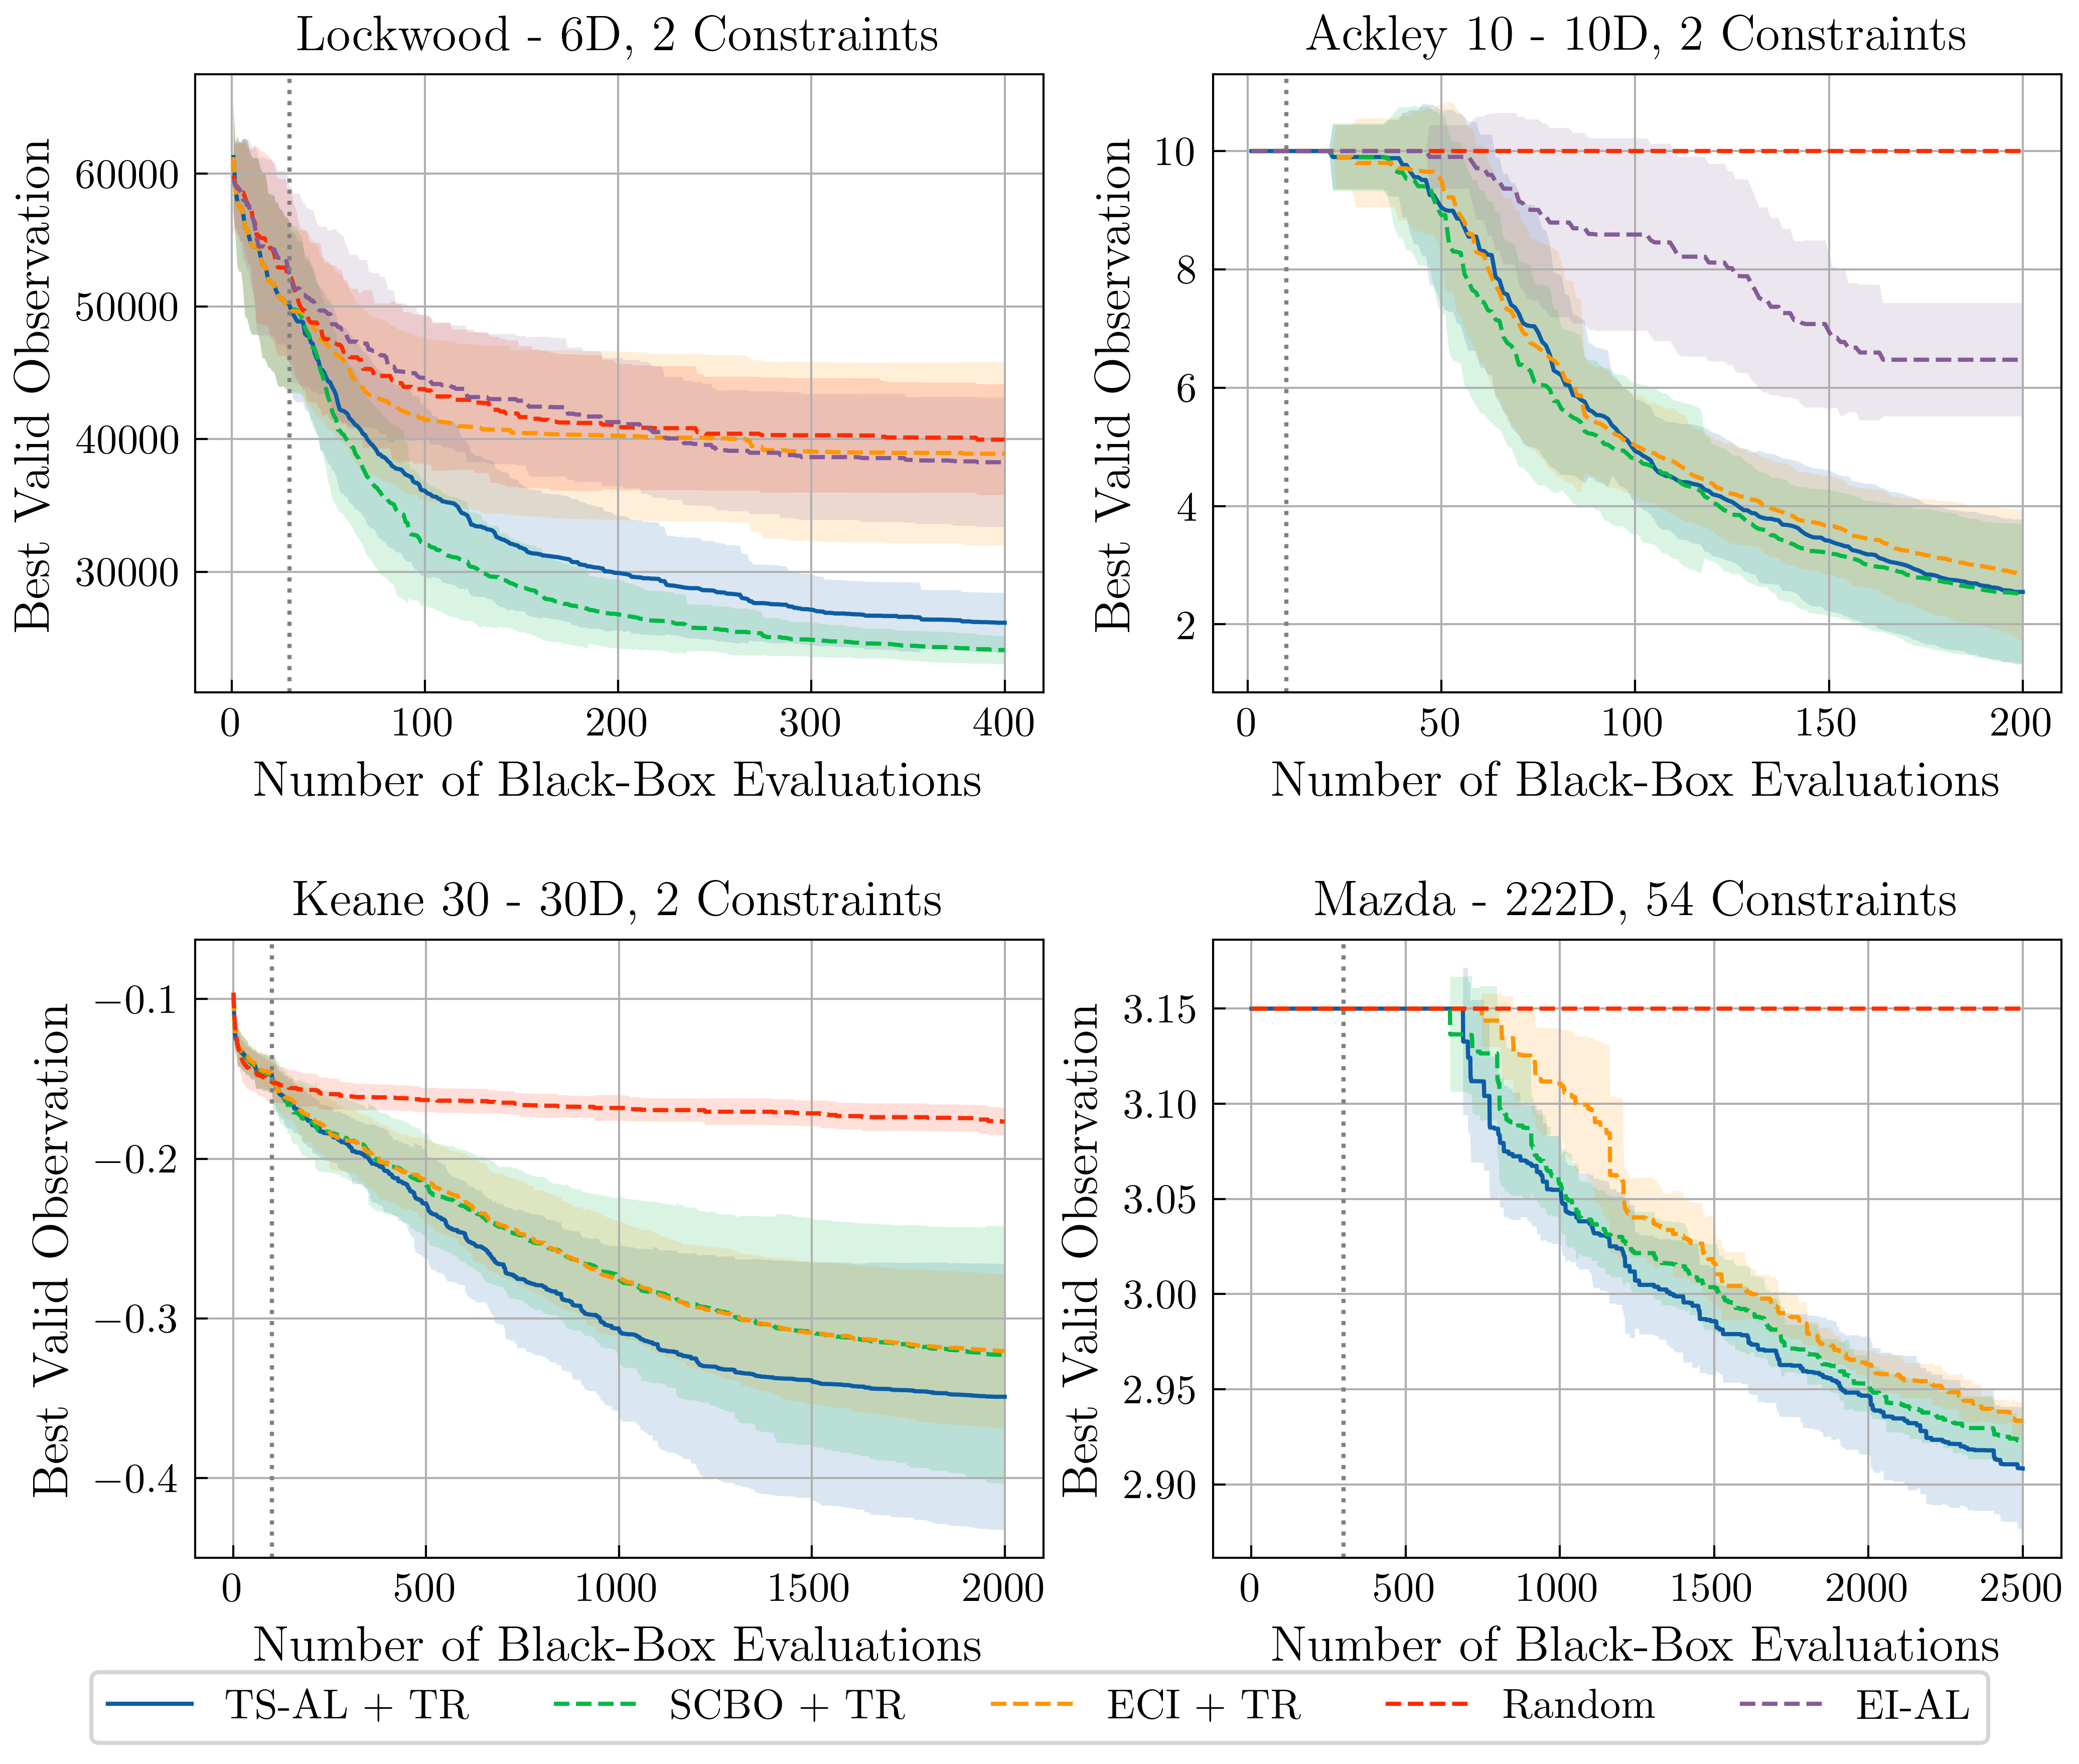

In [79]:
figure_mosaic = """
                AB
                CD
                """

plt.figure(figsize=(8, 6))
fig, axes = plt.subplot_mosaic(mosaic=figure_mosaic, figsize=(8, 6.4))
plt.subplots_adjust(hspace=0.4)


lockwood_iters = [i for i in range(1, 401)]
axes["A"].plot(lockwood_iters, ts_al_lockwood_mean, label="TS-AL + TR")
axes["A"].plot(lockwood_iters, scbo_lockwood_mean, label="SCBO + TR", linestyle="dashed")
axes["A"].plot(lockwood_iters, eci_lockwood_mean, label="ECI + TR", linestyle="dashed")
axes["A"].plot(lockwood_iters, random_lockwood_mean, label="Random", linestyle="dashed")
axes["A"].plot(lockwood_iters, ei_al_lockwood_mean, label="EI-AL", linestyle="dashed")
axes["A"].fill_between(lockwood_iters, ts_al_lockwood_mean - ts_al_lockwood_std, ts_al_lockwood_mean + ts_al_lockwood_std, alpha=0.15)
axes["A"].fill_between(lockwood_iters, scbo_lockwood_mean - sbco_lockwood_std, scbo_lockwood_mean + sbco_lockwood_std, alpha=0.15)
axes["A"].fill_between(lockwood_iters, eci_lockwood_mean - eci_lockwood_std, eci_lockwood_mean + eci_lockwood_std, alpha=0.15)
axes["A"].fill_between(lockwood_iters, random_lockwood_mean - random_lockwood_std, random_lockwood_mean + random_lockwood_std, alpha=0.15)
axes["A"].fill_between(lockwood_iters, ei_al_lockwood_mean - ei_al_lockwood_std, ei_al_lockwood_mean + ei_al_lockwood_std, alpha=0.15)
axes["A"].axvline(x=30, color="grey", linestyle="dotted")
axes["A"].set_title("Lockwood - 6D, 2 Constraints")
axes["A"].set_xlabel("Number of Black-Box Evaluations")
axes["A"].set_ylabel("Best Valid Observation")

ackley_iters = [i for i in range(1, 201)]
axes["B"].plot(ackley_iters, ts_al_ackley_10_mean, label="TS-AL + TR")
axes["B"].plot(ackley_iters, scbo_ackley_10_mean, label="SCBO + TR", linestyle="dashed")
axes["B"].plot(ackley_iters, eci_ackley_10_mean, label="ECI + TR", linestyle="dashed")
axes["B"].plot(ackley_iters, random_ackley_10_mean, label="Random", linestyle="dashed")
axes["B"].plot(ackley_iters, ei_al_ackley_10_mean, label="EI-AL", linestyle="dashed")
axes["B"].fill_between(ackley_iters, ts_al_ackley_10_mean - ts_al_ackley_10_std, ts_al_ackley_10_mean + ts_al_ackley_10_std, alpha=0.15)
axes["B"].fill_between(ackley_iters, scbo_ackley_10_mean - scbo_ackley_10_std, scbo_ackley_10_mean + scbo_ackley_10_std, alpha=0.15)
axes["B"].fill_between(ackley_iters, eci_ackley_10_mean - eci_ackley_10_std, eci_ackley_10_mean + eci_ackley_10_std, alpha=0.15)
axes["B"].fill_between(ackley_iters, random_ackley_10_mean - random_ackley_10_std, random_ackley_10_mean + random_ackley_10_std, alpha=0.15)
axes["B"].fill_between(ackley_iters, ei_al_ackley_10_mean - ei_al_ackley_10_std, ei_al_ackley_10_mean + ei_al_ackley_10_std, alpha=0.15)
axes["B"].axvline(x=10, color="grey", linestyle="dotted")
axes["B"].set_title("Ackley 10 - 10D, 2 Constraints")
axes["B"].set_xlabel("Number of Black-Box Evaluations")
axes["B"].set_ylabel("Best Valid Observation")

keane_30_iters = [i for i in range(1, 2001)]
axes["C"].plot(keane_30_iters, ts_al_keane_30_mean, label="TS-AL + TR")
axes["C"].plot(keane_30_iters, scbo_keane_30_mean, label="SCBO + TR", linestyle="dashed")
axes["C"].plot(keane_30_iters, eci_keane_30_mean, label="ECI + TR", linestyle="dashed")
axes["C"].plot(keane_30_iters, random_keane_30_mean, label="Random", linestyle="dashed")
axes["C"].fill_between(keane_30_iters, ts_al_keane_30_mean - ts_al_keane_30_std, ts_al_keane_30_mean + ts_al_keane_30_std, alpha=0.15)
axes["C"].fill_between(keane_30_iters, scbo_keane_30_mean - scbo_keane_30_std, scbo_keane_30_mean + scbo_keane_30_std, alpha=0.15)
axes["C"].fill_between(keane_30_iters, eci_keane_30_mean - eci_keane_30_std, eci_keane_30_mean + eci_keane_30_std, alpha=0.15)
axes["C"].fill_between(keane_30_iters, random_keane_30_mean - random_keane_30_std, random_keane_30_mean + random_keane_30_std, alpha=0.15)
axes["C"].axvline(x=100, color="grey", linestyle="dotted")
axes["C"].set_title("Keane 30 - 30D, 2 Constraints")
axes["C"].set_xlabel("Number of Black-Box Evaluations")
axes["C"].set_ylabel("Best Valid Observation")

mazda_iters = [i for i in range(1, 2501)]
axes["D"].plot(mazda_iters, ts_al_mazda_mean, label="TS-AL + TR")
axes["D"].plot(mazda_iters, scbo_mazda_mean, label="SCBO + TR", linestyle="dashed")
axes["D"].plot(mazda_iters, eci_mazda_mean, label="ECI +TR", linestyle="dashed")
axes["D"].plot(mazda_iters, random_mazda_mean, label="Random", linestyle="dashed")
axes["D"].fill_between(mazda_iters, ts_al_mazda_mean - ts_al_mazda_std, ts_al_mazda_mean + ts_al_mazda_std, alpha=0.15)
axes["D"].fill_between(mazda_iters, scbo_mazda_mean - scbo_mazda_std, scbo_mazda_mean + scbo_mazda_std, alpha=0.15)
axes["D"].fill_between(mazda_iters, eci_mazda_mean - eci_mazda_std, eci_mazda_mean + eci_mazda_std, alpha=0.15)
axes["D"].fill_between(mazda_iters, random_mazda_mean - random_mazda_std, random_mazda_mean + random_mazda_std, alpha=0.15)
axes["D"].axvline(x=300, color="grey", linestyle="dotted")
axes["D"].set_title("Mazda - 222D, 54 Constraints")
axes["D"].set_xlabel("Number of Black-Box Evaluations")
axes["D"].set_ylabel("Best Valid Observation")

# Add legend
handles, labels = axes["A"].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=5)

plt.savefig("paper_figs/combination_plot.png")